In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')
sns.set_palette("husl")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

PROJECT_ROOT = "."
DATASET_DIR = os.path.join(PROJECT_ROOT, "dataset")
REPORT_DIR = os.path.join(PROJECT_ROOT, "reports")
os.makedirs(REPORT_DIR, exist_ok=True)

print("COMP721 NBA PREDICTION — OUTLIER DETECTION (Refactored Pipeline)")


COMP721 NBA PREDICTION — OUTLIER DETECTION (Refactored Pipeline)


In [2]:
PLAYER_CAREER_FILE = os.path.join(DATASET_DIR, "player_regular_season_career.xlsx")
REQUIRED_COLUMNS = [
    'ilkid', 'firstname', 'lastname', 'gp', 'pts', 'reb', 'asts', 'stl', 'blk',
    'fga', 'fgm', 'fta', 'ftm', 'tpa', 'tpm', 'minutes', 'turnover'
]

if not os.path.isfile(PLAYER_CAREER_FILE):
    raise FileNotFoundError(f"Expected file not found: {PLAYER_CAREER_FILE}")

players_career = pd.read_excel(PLAYER_CAREER_FILE)
missing = [c for c in REQUIRED_COLUMNS if c not in players_career.columns]
if missing:
    raise KeyError(f"Missing required columns in {PLAYER_CAREER_FILE}: {missing}")

df = players_career.copy()


df = df[df['gp'].fillna(0) >= 100].copy()
print(f"Players with 100+ games: {len(df)}")


Players with 100+ games: 1993


In [3]:


def safe_div(numer, denom):
    numer = np.asarray(numer, dtype=float)
    denom = np.asarray(denom, dtype=float)
    return np.divide(numer, denom, out=np.zeros_like(numer), where=(denom != 0))

df['PPG'] = safe_div(df['pts'], df['gp'])
df['RPG'] = safe_div(df['reb'], df['gp'])
df['APG'] = safe_div(df['asts'], df['gp'])
df['MPG'] = safe_div(df['minutes'], df['gp'])
df['SPG'] = safe_div(df['stl'], df['gp'])
df['BPG'] = safe_div(df['blk'], df['gp'])

df['FG_PCT'] = safe_div(df['fgm'], df['fga'])
df['FT_PCT'] = safe_div(df['ftm'], df['fta'])
df['3P_PCT'] = safe_div(df['tpm'], df['tpa'])

df['PER_Simplified'] = safe_div(
    (df['pts'] + df['reb'] + df['asts'] + df['stl'] + df['blk']
     - (df['fga'] - df['fgm']) - (df['fta'] - df['ftm']) - df['turnover']),
    df['gp']
)

df['TS_PCT'] = safe_div(df['pts'], 2 * (df['fga'] + 0.44 * df['fta']))

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

print("Feature summary:")
for col in ['PPG', 'RPG', 'APG', 'PER_Simplified', 'TS_PCT']:
    print(f" - {col}: mean={df[col].mean():.3f} std={df[col].std():.3f}")


Feature summary:
 - PPG: mean=9.359 std=4.931
 - RPG: mean=4.089 std=2.670
 - APG: mean=2.063 std=1.498
 - PER_Simplified: mean=10.092 std=5.374
 - TS_PCT: mean=0.496 std=0.052


In [4]:

feature_columns = ['PPG', 'RPG', 'APG', 'PER_Simplified', 'TS_PCT', 'MPG']
X = df[feature_columns].values


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

all_methods = {}

print("\nZ-SCORE method:")
for col in ['PPG', 'RPG', 'APG', 'PER_Simplified']:
    col_vals = df[col].values
    if np.allclose(col_vals, col_vals[0]):
        print(f" - {col} is constant; skipping z-score.")
        all_methods[f"Z_{col}"] = set()
        continue
    z = np.abs(stats.zscore(col_vals, nan_policy='omit'))
    mask = z > 3
    out = set(df.loc[mask, 'ilkid'])
    all_methods[f"Z_{col}"] = out
    print(f" - {col}: {mask.sum()} outliers")

print("\nIQR method:")
for col in ['PPG', 'RPG', 'APG', 'PER_Simplified']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    if IQR == 0:
        print(f" - {col} IQR=0; skipping.")
        all_methods[f"IQR_{col}"] = set()
        continue
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (df[col] < lower) | (df[col] > upper)
    out = set(df.loc[mask, 'ilkid'])
    all_methods[f"IQR_{col}"] = out
    print(f" - {col}: {mask.sum()} outliers")

iso = IsolationForest(contamination=0.05, random_state=42)
iso_preds = iso.fit_predict(X_scaled)
iso_mask = iso_preds == -1
iso_out = set(df.loc[iso_mask, 'ilkid'])
all_methods['IsolationForest'] = iso_out
print(f"\nIsolationForest: {iso_mask.sum()} outliers")

dbscan = DBSCAN(eps=2.5, min_samples=10)
db_labels = dbscan.fit_predict(X_scaled)
db_mask = db_labels == -1
db_out = set(df.loc[db_mask, 'ilkid'])
all_methods['DBSCAN'] = db_out
print(f"DBSCAN (eps=2.5, min_samples=10): {db_mask.sum()} outliers")



Z-SCORE method:
 - PPG: 22 outliers
 - RPG: 25 outliers
 - APG: 34 outliers
 - PER_Simplified: 26 outliers

IQR method:
 - PPG: 47 outliers
 - RPG: 67 outliers
 - APG: 76 outliers
 - PER_Simplified: 41 outliers

IsolationForest: 100 outliers
DBSCAN (eps=2.5, min_samples=10): 4 outliers


In [5]:

outlier_counts = {pid: 0 for pid in df['ilkid']}
for method, out_set in all_methods.items():
    for pid in out_set:
        outlier_counts[pid] = outlier_counts.get(pid, 0) + 1

df['Outlier_Count'] = df['ilkid'].map(outlier_counts).fillna(0).astype(int)
df['Consensus_Outlier'] = df['Outlier_Count'] >= 2
print(f"\nConsensus outliers (flagged by >=2 methods): {df['Consensus_Outlier'].sum()} players")

outliers_df = df[df['Consensus_Outlier']].copy()
outliers_path = os.path.join(REPORT_DIR, "consensus_outliers.csv")
outliers_df.to_csv(outliers_path, index=False)
print(f"Saved consensus outliers -> {outliers_path}")



Consensus outliers (flagged by >=2 methods): 101 players
Saved consensus outliers -> .\reports\consensus_outliers.csv


In [6]:

print("=" * 70)
print("TOP 10 CONSENSUS OUTLIERS (Flagged by 2+ Methods)")
print("=" * 70)

top_outliers = df[df['Consensus_Outlier']].nlargest(10, 'Outlier_Count')[
    ['firstname', 'lastname', 'Outlier_Count', 'PPG', 'RPG', 'APG', 'PER_Simplified']
]

for idx, (_, row) in enumerate(top_outliers.iterrows(), 1):
    print(f"{idx:2d}. {row['firstname']} {row['lastname']:<20}"
          f" | Outlier Votes: {row['Outlier_Count']}"
          f" | PPG: {row['PPG']:5.1f}"
          f" | RPG: {row['RPG']:4.1f}"
          f" | APG: {row['APG']:4.1f}"
          f" | PER: {row['PER_Simplified']:5.1f}")

print("=" * 70)

print("\nTop 10 Outliers (Tabular Format):")
display_cols = ['firstname', 'lastname', 'Outlier_Count', 'PPG', 'RPG', 'APG', 'PER_Simplified']
top_outliers_display = top_outliers[display_cols].copy()
top_outliers_display.columns = ['First Name', 'Last Name', 'Outlier Votes', 'PPG', 'RPG', 'APG', 'PER']
print(top_outliers_display.to_string(index=False))

print(f"\nTotal consensus outliers found: {df['Consensus_Outlier'].sum()} players")

TOP 10 CONSENSUS OUTLIERS (Flagged by 2+ Methods)
 1. Wilt Chamberlain          | Outlier Votes: 8 | PPG:  30.1 | RPG: 22.9 | APG:  4.4 | PER:  41.5
 2. Elgin Baylor               | Outlier Votes: 7 | PPG:  27.4 | RPG: 13.5 | APG:  4.3 | PER:  29.7
 3. Julius Erving               | Outlier Votes: 7 | PPG:  28.7 | RPG: 12.1 | APG:  4.8 | PER:  32.3
 4. Julius Erving               | Outlier Votes: 7 | PPG:  22.0 | RPG:  6.7 | APG:  3.9 | PER:  23.4
 5. Connie Hawkins              | Outlier Votes: 7 | PPG:  28.2 | RPG: 12.6 | APG:  4.3 | PER:  30.3
 6. Connie Hawkins              | Outlier Votes: 7 | PPG:  16.5 | RPG:  8.0 | APG:  4.1 | PER:  21.3
 7. Bob Pettit               | Outlier Votes: 7 | PPG:  26.4 | RPG: 16.2 | APG:  3.0 | PER:  31.1
 8. Oscar Robertson            | Outlier Votes: 7 | PPG:  25.7 | RPG:  7.5 | APG:  9.5 | PER:  31.6
 9. Jerry West                 | Outlier Votes: 7 | PPG:  27.0 | RPG:  5.8 | APG:  6.7 | PER:  27.1
10. Kareem Abdul-jabbar         | Outlier Votes: 

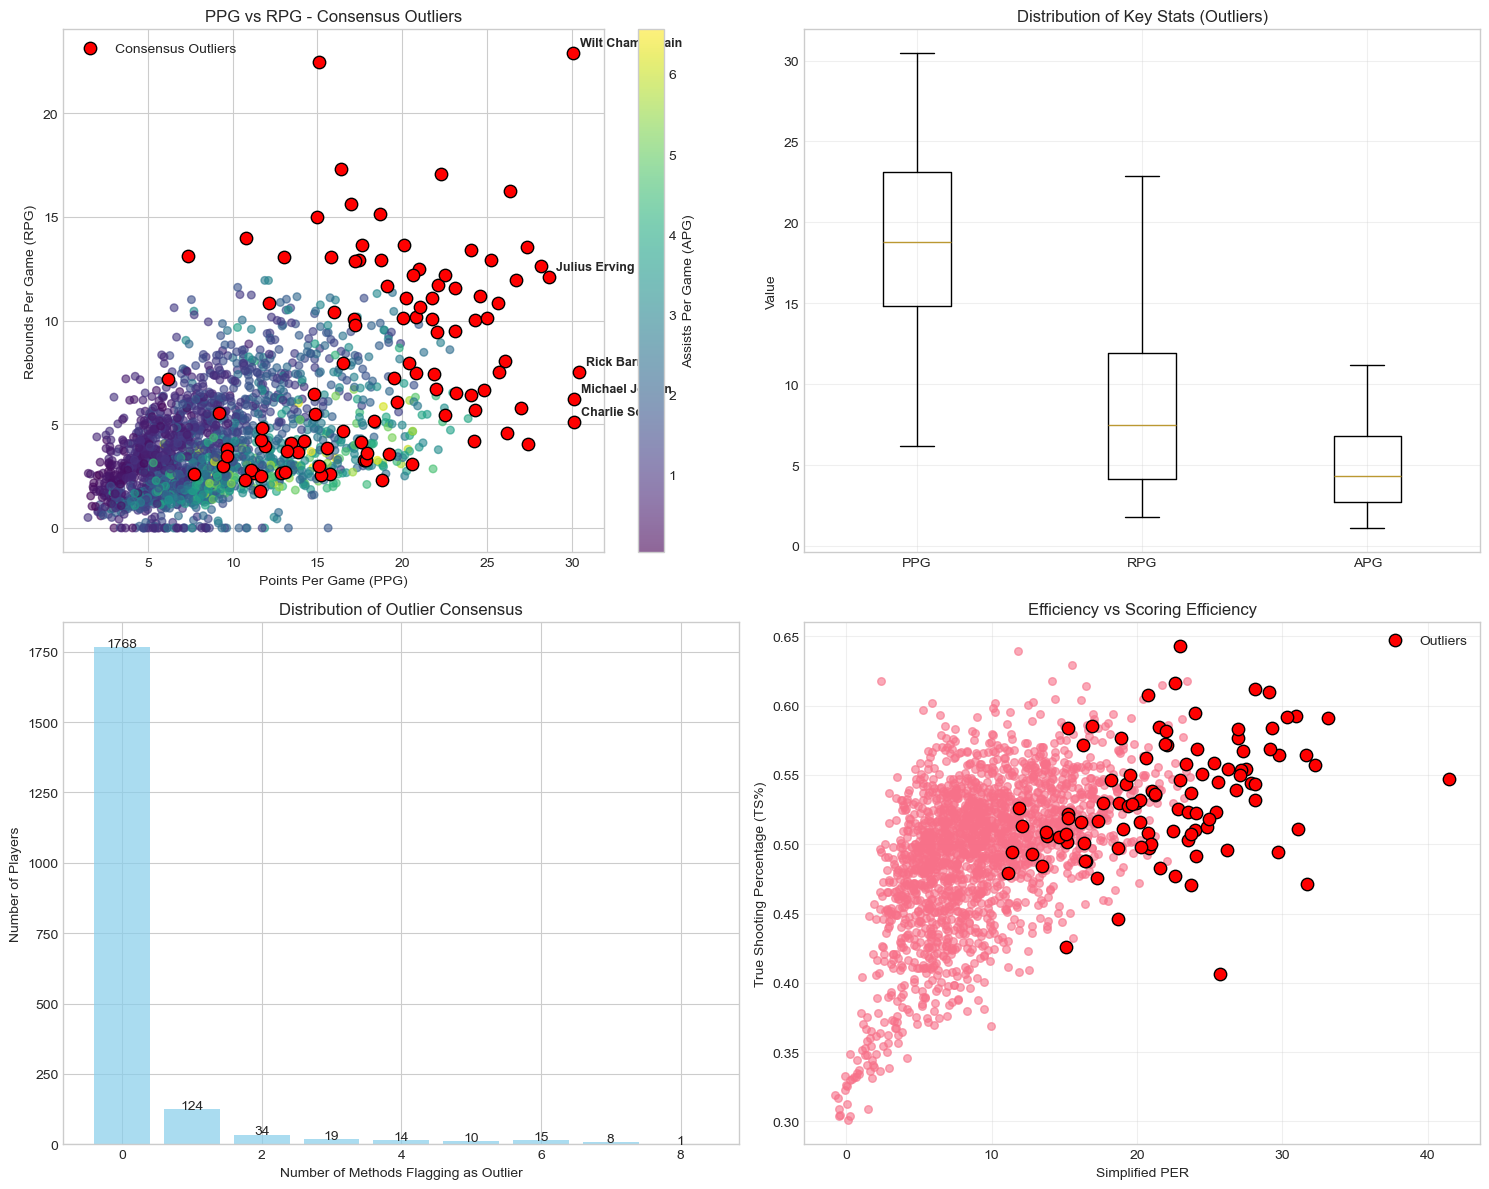

Saved visualization -> .\reports\outlier_detection_visualizations.png


In [7]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
regular_df = df[~df['Consensus_Outlier']]
outliers_df = df[df['Consensus_Outlier']]

sc = axes[0,0].scatter(regular_df['PPG'], regular_df['RPG'], alpha=0.6,
                      c=regular_df['APG'], cmap='viridis', s=30)
axes[0,0].scatter(outliers_df['PPG'], outliers_df['RPG'], color='red', s=80,
                  label='Consensus Outliers', edgecolors='black', linewidth=1)
if 'firstname' in df.columns and 'lastname' in df.columns:
    top_out = outliers_df.nlargest(5, 'PPG')
    for _, r in top_out.iterrows():
        axes[0,0].annotate(f"{r['firstname']} {r['lastname']}",
                           (r['PPG'], r['RPG']), xytext=(5,5),
                           textcoords='offset points', fontsize=9, fontweight='bold')
axes[0,0].set_xlabel('Points Per Game (PPG)')
axes[0,0].set_ylabel('Rebounds Per Game (RPG)')
axes[0,0].set_title('PPG vs RPG - Consensus Outliers')
axes[0,0].legend()
plt.colorbar(sc, ax=axes[0,0], label='Assists Per Game (APG)')

box_data = [outliers_df[col] for col in ['PPG', 'RPG', 'APG']]
axes[0,1].boxplot(box_data, labels=['PPG', 'RPG', 'APG'])
axes[0,1].set_ylabel('Value')
axes[0,1].set_title('Distribution of Key Stats (Outliers)')
axes[0,1].grid(True, alpha=0.3)

oc = df['Outlier_Count'].value_counts().sort_index()
axes[1,0].bar(oc.index, oc.values, color='skyblue', alpha=0.7)
axes[1,0].set_xlabel('Number of Methods Flagging as Outlier')
axes[1,0].set_ylabel('Number of Players')
axes[1,0].set_title('Distribution of Outlier Consensus')
for i, v in enumerate(oc.values):
    axes[1,0].text(oc.index[i], v + 0.5, str(v), ha='center')

axes[1,1].scatter(regular_df['PER_Simplified'], regular_df['TS_PCT'], alpha=0.6, s=30)
axes[1,1].scatter(outliers_df['PER_Simplified'], outliers_df['TS_PCT'],
                  color='red', s=80, label='Outliers', edgecolors='black')
axes[1,1].set_xlabel('Simplified PER')
axes[1,1].set_ylabel('True Shooting Percentage (TS%)')
axes[1,1].set_title('Efficiency vs Scoring Efficiency')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
out_png = os.path.join(REPORT_DIR, "outlier_detection_visualizations.png")
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved visualization -> {out_png}")


In [60]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {DEVICE}")


Running on device: cpu


In [61]:

def load_and_preprocess_team_data():
    """Load and preprocess team season data with robust error handling"""
    DATASET_DIR = "dataset"
    TEAM_STATS_FILE = os.path.join(DATASET_DIR, "team_season.xlsx")
    
    if not os.path.isfile(TEAM_STATS_FILE):
        raise FileNotFoundError(f"Missing dataset: {TEAM_STATS_FILE}")
    
    team_stats = pd.read_excel(TEAM_STATS_FILE)
    print(f"Original data shape: {team_stats.shape}")
    
    team_stats.columns = (
        team_stats.columns.str.lower()
        .str.strip()
        .str.replace(' ', '_', regex=False)
        .str.replace('%', 'pct', regex=False)
        .str.replace('/', '_per_', regex=False)
    )
    
    team_col = 'team'
    season_col = 'year'
    
    print("Removing seasons with incomplete data...")
    original_count = len(team_stats)
    team_stats = team_stats[team_stats['o_pts'] > 1000].copy() 
    removed_count = original_count - len(team_stats)
    print(f"Removed {removed_count} records with incomplete data")
    
    print("Creating robust basketball features...")
    
    team_stats['games_played'] = team_stats['won'] + team_stats['lost']
    team_stats['win_pct'] = team_stats['won'] / team_stats['games_played']
    
    team_stats['net_rating'] = team_stats['o_pts'] - team_stats['d_pts']
    
    team_stats['pace_safe'] = team_stats['pace'].replace(0, 100) 
    team_stats['offensive_efficiency'] = team_stats['o_pts'] / team_stats['pace_safe']
    team_stats['defensive_efficiency'] = team_stats['d_pts'] / team_stats['pace_safe']
    team_stats['net_efficiency'] = team_stats['offensive_efficiency'] - team_stats['defensive_efficiency']
    
    meaningful_features = [
        'win_pct', 'net_rating', 'net_efficiency',
        'offensive_efficiency', 'defensive_efficiency',
        'o_pts', 'd_pts', 'pace'
    ]
    
    print("Cleaning extreme values...")
    for feature in meaningful_features:
        team_stats[feature] = team_stats[feature].replace([np.inf, -np.inf], np.nan)
        q99 = team_stats[feature].quantile(0.99)
        q01 = team_stats[feature].quantile(0.01)
        team_stats[feature] = np.clip(team_stats[feature], q01, q99)
    
    team_stats[meaningful_features] = team_stats[meaningful_features].fillna(team_stats[meaningful_features].median())
    
    print(f"Using {len(meaningful_features)} meaningful basketball features:")
    for feature in meaningful_features:
        stats = team_stats[feature].describe()
        print(f"  - {feature}: mean={stats['mean']:.1f}, range=[{stats['min']:.1f}, {stats['max']:.1f}]")
    
    return team_stats, team_col, season_col, meaningful_features

team_stats, TEAM_COL, SEASON_COL, FEATURES = load_and_preprocess_team_data()
df = team_stats[[TEAM_COL, SEASON_COL] + FEATURES].copy()

print(f"\nFinal dataset shape: {df.shape}")
print(f"Seasons: {df[SEASON_COL].nunique()} ({df[SEASON_COL].min()} to {df[SEASON_COL].max()})")
print(f"Teams: {df[TEAM_COL].nunique()}")

Original data shape: (1187, 36)
Removing seasons with incomplete data...
Removed 0 records with incomplete data
Creating robust basketball features...
Cleaning extreme values...
Using 8 meaningful basketball features:
  - win_pct: mean=0.5, range=[0.2, 0.8]
  - net_rating: mean=-0.3, range=[-840.0, 743.3]
  - net_efficiency: mean=-0.0, range=[-8.7, 7.4]
  - offensive_efficiency: mean=82.5, range=[36.7, 99.9]
  - defensive_efficiency: mean=82.5, range=[38.4, 99.2]
  - o_pts: mean=8238.3, range=[3669.2, 10004.0]
  - d_pts: mean=8238.9, range=[3844.3, 10025.1]
  - pace: mean=67.5, range=[0.0, 113.0]

Final dataset shape: (1187, 10)
Seasons: 59 (1946 to 2004)
Teams: 91


In [62]:

def generate_realistic_matchups(team_df, team_col, season_col, features, n_matchups_per_season=50):
    """Generate realistic team matchups with robust error handling"""
    
    print("Applying safe feature scaling...")
    team_df_normalized = team_df.copy()
    
    for feature in features:
        if feature in ['win_pct']: 
            team_df_normalized[feature] = team_df_normalized[feature]
        else:
            median_val = team_df_normalized[feature].median()
            q75 = team_df_normalized[feature].quantile(0.75)
            q25 = team_df_normalized[feature].quantile(0.25)
            iqr = q75 - q25
            
            if iqr > 0:  
                team_df_normalized[feature] = (team_df_normalized[feature] - median_val) / iqr
            else:
                team_df_normalized[feature] = 0
    
    matchups = []
    seasons = team_df_normalized[season_col].unique()
    
    print("Generating REALISTIC basketball matchups...")
    print("-" * 80)
    
    for season in sorted(seasons)[:10]:  
        season_teams = team_df_normalized[team_df_normalized[season_col] == season]
        if len(season_teams) < 2:
            continue
            
        team_list = season_teams[[team_col] + features].values
        team_names = season_teams[team_col].values
        
        print(f"\nSeason {season}: {len(season_teams)} teams")
        
        season_matchups = []
        match_count = 0
        
        while match_count < n_matchups_per_season and match_count < len(team_names) * 2:
            i, j = np.random.choice(len(team_list), 2, replace=False)
            team_a, team_b = team_list[i], team_list[j]
            name_a, name_b = team_names[i], team_names[j]
            
            if name_a == name_b:
                continue
            
            feature_diff = team_a[1:] - team_b[1:] 
            
            try:
                
                win_pct_idx = features.index('win_pct') if 'win_pct' in features else 0
                win_pct_diff = feature_diff[win_pct_idx]
                
              
                net_eff_idx = features.index('net_efficiency') if 'net_efficiency' in features else win_pct_idx
                net_eff_diff = feature_diff[net_eff_idx]
                
                strength_diff = 0.7 * win_pct_diff + 0.3 * net_eff_diff
                
                win_probability = 1 / (1 + np.exp(-strength_diff * 3.0))
                
                win_probability = np.clip(win_probability, 0.25, 0.85)
                
                team_a_wins = 1 if np.random.random() < win_probability else 0
                
                matchup_data = {
                    'team_a': name_a,
                    'team_b': name_b,
                    'season': season,
                    'team_a_wins': team_a_wins,
                    'win_probability': win_probability
                }
                matchups.append(matchup_data)
                season_matchups.append(f"{name_a} vs {name_b} (A wins: {team_a_wins}, prob: {win_probability:.2f})")
                match_count += 1
                
            except (IndexError, ValueError) as e:
                print(f"Error processing matchup: {e}")
                continue
        
        if season_matchups:
            print(f"  Sample matchups:")
            for matchup in season_matchups[:3]:
                print(f"    {matchup}")
        else:
            print(f" No valid matchups generated for season {season}")
    
    if not matchups:
        raise ValueError("No matchups were generated! Check your data quality.")
    
    matchup_df = pd.DataFrame(matchups)
    
    print("\n" + "=" * 80)
    print("MATCHUP GENERATION SUMMARY")
    print("=" * 80)
    print(f"Total matchups generated: {len(matchup_df)}")
    print(f"Seasons covered: {matchup_df['season'].nunique()}")
    print(f"Probability range: {matchup_df['win_probability'].min():.2f} to {matchup_df['win_probability'].max():.2f}")
    print(f"Average win probability: {matchup_df['win_probability'].mean():.2f}")
    print(f"Team A win rate: {matchup_df['team_a_wins'].mean():.2f}")
    
    prob_stats = matchup_df['win_probability'].describe()
    if prob_stats['std'] < 0.1:
        print("Warning: Probabilities are too similar")
    elif prob_stats['std'] > 0.3:
        print("Warning: Probabilities are too extreme")
    else:
        print("Probabilities are well distributed")
    
    return matchup_df

print("Starting matchup generation...")
matchup_df = generate_realistic_matchups(df, TEAM_COL, SEASON_COL, FEATURES, n_matchups_per_season=20)

Starting matchup generation...
Applying safe feature scaling...
Generating REALISTIC basketball matchups...
--------------------------------------------------------------------------------

Season 1946: 11 teams
  Sample matchups:
    PIT vs PRO (A wins: 0, prob: 0.27)
    DE1 vs NYK (A wins: 1, prob: 0.32)
    PRO vs ST1 (A wins: 0, prob: 0.31)

Season 1947: 8 teams
  Sample matchups:
    CH1 vs PRO (A wins: 1, prob: 0.85)
    NYK vs WSC (A wins: 0, prob: 0.49)
    BA1 vs CH1 (A wins: 0, prob: 0.53)

Season 1948: 12 teams
  Sample matchups:
    BA1 vs PH1 (A wins: 0, prob: 0.54)
    ST1 vs INJ (A wins: 1, prob: 0.62)
    INJ vs FTW (A wins: 0, prob: 0.42)

Season 1949: 17 teams
  Sample matchups:
    WSC vs SHE (A wins: 1, prob: 0.68)
    BOS vs AND (A wins: 1, prob: 0.25)
    WSC vs TRI (A wins: 0, prob: 0.50)

Season 1950: 11 teams
  Sample matchups:
    FTW vs BOS (A wins: 1, prob: 0.40)
    ROC vs FTW (A wins: 0, prob: 0.71)
    SYR vs INI (A wins: 1, prob: 0.60)

Season 1951: 10 

In [63]:

print("Available columns in matchup_df:")
print(matchup_df.columns.tolist())

diff_columns = [c for c in matchup_df.columns if c.startswith('diff_')]
print(f"Found {len(diff_columns)} diff_ columns: {diff_columns}")

if len(diff_columns) == 0:
    print("No diff_ features found. Need to regenerate matchups with feature differences...")
    
    def generate_matchups_with_features(team_df, team_col, season_col, features, n_matchups_per_season=50):
        """Generate matchups including feature differences for model training"""
        matchups = []
        seasons = team_df[season_col].unique()
        
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        team_df_normalized = team_df.copy()
        team_df_normalized[features] = scaler.fit_transform(team_df[features])
        
        for season in sorted(seasons)[:10]:  
            season_teams = team_df_normalized[team_df_normalized[season_col] == season]
            if len(season_teams) < 2:
                continue
                
            team_list = season_teams[[team_col] + features].values
            team_names = season_teams[team_col].values
            
            for match_num in range(n_matchups_per_season):
                i, j = np.random.choice(len(team_list), 2, replace=False)
                team_a, team_b = team_list[i], team_list[j]
                name_a, name_b = team_names[i], team_names[j]
                
                if name_a == name_b:
                    continue
                
                feature_diff = team_a[1:] - team_b[1:]  
                
                win_pct_idx = features.index('win_pct') if 'win_pct' in features else 0
                win_pct_diff = feature_diff[win_pct_idx]
                
                net_eff_idx = features.index('net_efficiency') if 'net_efficiency' in features else win_pct_idx
                net_eff_diff = feature_diff[net_eff_idx]
                
                strength_diff = 0.7 * win_pct_diff + 0.3 * net_eff_diff
                win_probability = 1 / (1 + np.exp(-strength_diff * 3.0))
                win_probability = np.clip(win_probability, 0.25, 0.85)
                
                team_a_wins = 1 if np.random.random() < win_probability else 0
                
                matchup_data = {
                    'team_a': name_a,
                    'team_b': name_b,
                    'season': season,
                    'team_a_wins': team_a_wins,
                    'win_probability': win_probability,
                    **{f'diff_{features[k]}': feature_diff[k] for k in range(len(features))}
                }
                matchups.append(matchup_data)
        
        return pd.DataFrame(matchups)
    
    matchup_df = generate_matchups_with_features(df, TEAM_COL, SEASON_COL, FEATURES, n_matchups_per_season=20)
    print(f"Regenerated matchups with feature differences. New shape: {matchup_df.shape}")
    print("New columns:", matchup_df.columns.tolist())

diff_columns = [c for c in matchup_df.columns if c.startswith('diff_')]
print(f"\nUsing {len(diff_columns)} feature differences for model training")

if len(diff_columns) == 0:
    raise ValueError("No feature differences found! Cannot train model.")

X = matchup_df[diff_columns].values
y = matchup_df['team_a_wins'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"\nData split completed:")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total samples: {len(X_train) + len(X_val) + len(X_test)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling applied:")
print(f"Training set - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")
print(f"Validation set - Mean: {X_val_scaled.mean():.3f}, Std: {X_val_scaled.std():.3f}")

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(DEVICE)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(DEVICE)
y_val_t = torch.tensor(y_val, dtype=torch.long).to(DEVICE)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(DEVICE)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(DEVICE)

print(f"\nPyTorch tensors created:")
print(f"X_train_t shape: {X_train_t.shape}, device: {X_train_t.device}")
print(f"y_train_t shape: {y_train_t.shape}, device: {y_train_t.device}")

print(f"\nClass distribution in splits:")
print(f"Train: {torch.bincount(y_train_t).tolist()}") 
print(f"Val: {torch.bincount(y_val_t).tolist()}")
print(f"Test: {torch.bincount(y_test_t).tolist()}")

Available columns in matchup_df:
['team_a', 'team_b', 'season', 'team_a_wins', 'win_probability']
Found 0 diff_ columns: []
No diff_ features found. Need to regenerate matchups with feature differences...
Regenerated matchups with feature differences. New shape: (200, 13)
New columns: ['team_a', 'team_b', 'season', 'team_a_wins', 'win_probability', 'diff_win_pct', 'diff_net_rating', 'diff_net_efficiency', 'diff_offensive_efficiency', 'diff_defensive_efficiency', 'diff_o_pts', 'diff_d_pts', 'diff_pace']

Using 8 feature differences for model training
Feature matrix shape: (200, 8)
Target vector shape: (200,)
Class distribution: [ 88 112]

Data split completed:
Training samples: 120 (60.0%)
Validation samples: 40 (20.0%)
Testing samples: 40 (20.0%)
Total samples: 200

Feature scaling applied:
Training set - Mean: -0.000, Std: 0.935
Validation set - Mean: 0.105, Std: 1.037

PyTorch tensors created:
X_train_t shape: torch.Size([120, 8]), device: cpu
y_train_t shape: torch.Size([120]), devi

In [64]:


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class RegularizedModelComparator:
    """Compare multiple regularized machine learning models for game outcome prediction"""
    
    def __init__(self, X_train, X_val, X_test, y_train, y_val, y_test):
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        self.models = {}
        self.results = {}
        
    def initialize_models(self):
        """Initialize ML models with strong regularization to prevent overfitting"""
        self.models = {
            'LogisticRegression': LogisticRegression(
                random_state=42, max_iter=2000, C=0.01, penalty='l2', solver='liblinear'
            ),
            'RandomForest': RandomForestClassifier(
                n_estimators=50, max_depth=5, min_samples_split=20, 
                min_samples_leaf=10, max_features=0.5, random_state=42, n_jobs=-1
            ),
            'GradientBoosting': GradientBoostingClassifier(
                n_estimators=50, learning_rate=0.05, max_depth=3, 
                min_samples_split=20, min_samples_leaf=10, subsample=0.7,
                max_features=0.6, random_state=42
            ),
            'SupportVectorMachine': SVC(
                C=0.01, kernel='linear', gamma='scale', probability=True, 
                random_state=42, cache_size=1000
            ),
            'XGBoost': xgb.XGBClassifier(
                n_estimators=50, max_depth=3, learning_rate=0.05, 
                subsample=0.7, colsample_bytree=0.7, reg_alpha=1.0, 
                reg_lambda=1.0, gamma=0.1, min_child_weight=3,
                random_state=42, eval_metric='logloss', n_jobs=-1
            )
        }
        
    def train_and_evaluate_models(self):
        """Train and evaluate all models with proper overfitting analysis"""
        print("Training and evaluating regularized ML models...")
        
        for name, model in self.models.items():
            try:
                cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='accuracy')
                cv_mean = cv_scores.mean()
                cv_std = cv_scores.std()
                
                model.fit(self.X_train, self.y_train)
                
                y_train_pred = model.predict(self.X_train)
                y_val_pred = model.predict(self.X_val)
                y_test_pred = model.predict(self.X_test)
                
                y_train_proba = model.predict_proba(self.X_train)[:, 1] if hasattr(model, "predict_proba") else None
                y_val_proba = model.predict_proba(self.X_val)[:, 1] if hasattr(model, "predict_proba") else None
                y_test_proba = model.predict_proba(self.X_test)[:, 1] if hasattr(model, "predict_proba") else None
                
                train_accuracy = accuracy_score(self.y_train, y_train_pred)
                val_accuracy = accuracy_score(self.y_val, y_val_pred)
                test_accuracy = accuracy_score(self.y_test, y_test_pred)
                
                train_f1 = f1_score(self.y_train, y_train_pred, zero_division=0)
                val_f1 = f1_score(self.y_val, y_val_pred, zero_division=0)
                test_f1 = f1_score(self.y_test, y_test_pred, zero_division=0)
                
                train_auc = roc_auc_score(self.y_train, y_train_proba) if y_train_proba is not None else None
                val_auc = roc_auc_score(self.y_val, y_val_proba) if y_val_proba is not None else None
                test_auc = roc_auc_score(self.y_test, y_test_proba) if y_test_proba is not None else None
                
                train_val_overfitting_gap = train_accuracy - val_accuracy
                val_test_generalization_gap = val_accuracy - test_accuracy
                
                self.results[name] = {
                    'model': model,
                    'train_accuracy': train_accuracy,
                    'train_f1': train_f1,
                    'train_auc': train_auc,
                    'val_accuracy': val_accuracy,
                    'val_f1': val_f1,
                    'val_auc': val_auc,
                    'test_accuracy': test_accuracy,
                    'test_f1': test_f1,
                    'test_auc': test_auc,
                    'cv_mean_accuracy': cv_mean,
                    'cv_std_accuracy': cv_std,
                    'train_val_overfitting_gap': train_val_overfitting_gap,
                    'val_test_generalization_gap': val_test_generalization_gap
                }
                
                print(f"Completed: {name}")
                
            except Exception as e:
                print(f"Error with {name}: {str(e)}")
                continue
    
    def display_comparison(self):
        """Display comprehensive comparison of all models"""
        print("\nModel Comparison Summary:")
        print("=" * 100)
        
        comparison_data = []
        for name, result in self.results.items():
            comparison_data.append({
                'Model': name,
                'Train_Acc': f"{result['train_accuracy']:.4f}",
                'Val_Acc': f"{result['val_accuracy']:.4f}",
                'Test_Acc': f"{result['test_accuracy']:.4f}",
                'Train-Val_Gap': f"{result['train_val_overfitting_gap']:.4f}",
                'Val-Test_Gap': f"{result['val_test_generalization_gap']:.4f}",
                'Test_F1': f"{result['test_f1']:.4f}",
                'Test_AUC': f"{result['test_auc']:.4f}" if result['test_auc'] else "N/A"
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        suitable_models = {}
        for name, result in self.results.items():
            if (result['train_val_overfitting_gap'] <= 0.05 and 
                abs(result['val_test_generalization_gap']) <= 0.05):
                suitable_models[name] = result
        
        if suitable_models:
            best_model_name = max(suitable_models.items(), key=lambda x: x[1]['test_accuracy'])[0]
            best_model_result = suitable_models[best_model_name]
            print(f"\nBest Model (Low Overfitting & Good Generalization): {best_model_name}")
        else:
            best_model_name = min(self.results.items(), key=lambda x: abs(x[1]['train_val_overfitting_gap']))[0]
            best_model_result = self.results[best_model_name]
            print(f"\nBest Model (Lowest Overfitting): {best_model_name}")
        
        print(f"Train-Val Overfitting Gap: {best_model_result['train_val_overfitting_gap']:.4f}")
        print(f"Val-Test Generalization Gap: {best_model_result['val_test_generalization_gap']:.4f}")
        print(f"Test Accuracy: {best_model_result['test_accuracy']:.4f}")
        print(f"Test F1-Score: {best_model_result['test_f1']:.4f}")
        print(f"Test AUC: {best_model_result['test_auc']:.4f}")
        
        return best_model_name, best_model_result['model']
    
    def evaluate_best_model(self, best_model, best_model_name):
        """Evaluate the best model on test set"""
        print(f"\nDetailed Test Set Evaluation - {best_model_name}:")
        print("=" * 50)
        
        if not hasattr(best_model, 'classes_'):
            best_model.fit(self.X_train, self.y_train)
        
        y_test_pred = best_model.predict(self.X_test)
        y_test_proba = best_model.predict_proba(self.X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
        
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        test_precision = precision_score(self.y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(self.y_test, y_test_pred, zero_division=0)
        test_f1 = f1_score(self.y_test, y_test_pred, zero_division=0)
        test_auc = roc_auc_score(self.y_test, y_test_proba) if y_test_proba is not None else None
        
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print(f"Test AUC: {test_auc:.4f}" if test_auc else "Test AUC: N/A")
        
        cm = confusion_matrix(self.y_test, y_test_pred)
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"\nClassification Report:\n{classification_report(self.y_test, y_test_pred)}")
        
        return {
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'test_auc': test_auc
        }

model_comparator = RegularizedModelComparator(X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test)
model_comparator.initialize_models()
model_comparator.train_and_evaluate_models()
best_model_name, best_model = model_comparator.display_comparison()
test_results = model_comparator.evaluate_best_model(best_model, best_model_name)



class RegularizedNeuralNetwork(nn.Module):
    """Neural Network with strong regularization for basketball game outcome prediction"""
    
    def __init__(self, input_size, hidden_sizes=[32, 16], dropout_rate=0.5):
        super(RegularizedNeuralNetwork, self).__init__()
        
        layers = []
        prev_size = input_size
        
        layers.append(nn.Dropout(dropout_rate))
        
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 2))
        
        self.network = nn.Sequential(*layers)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        
    def forward(self, x):
        return self.network(x)

def train_regularized_neural_network(X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t, input_size, epochs=200, patience=20):
    """Train neural network with strong regularization and early stopping"""
    print("\nTraining Regularized Neural Network...")
    
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = RegularizedNeuralNetwork(input_size=input_size, dropout_rate=0.5).to(DEVICE)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_val_accuracy = 0
    patience_counter = 0
    best_model_state = None
    
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        if epoch % 3 == 0:
            noise = torch.randn_like(X_train_t) * 0.01
            inputs = X_train_t + noise
        else:
            inputs = X_train_t
            
        outputs = model(inputs)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_t)
            _, val_preds = torch.max(val_outputs, 1)
            val_accuracy = (val_preds == y_val_t).float().mean().item()
            val_loss = criterion(val_outputs, y_val_t).item()
            
            train_outputs = model(X_train_t)
            _, train_preds = torch.max(train_outputs, 1)
            train_accuracy = (train_preds == y_train_t).float().mean().item()
            
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
        
        scheduler.step(val_loss)
        
        if epoch % 50 == 0:
            current_overfitting_gap = train_accuracy - val_accuracy
            print(f'Epoch {epoch}: Train Loss = {loss.item():.4f}, Train Acc = {train_accuracy:.4f}, Val Acc = {val_accuracy:.4f}, Overfit Gap = {current_overfitting_gap:.4f}')
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_t)
        _, train_preds = torch.max(train_outputs, 1)
        final_train_accuracy = (train_preds == y_train_t).float().mean().item()
        
        val_outputs = model(X_val_t)
        _, val_preds = torch.max(val_outputs, 1)
        final_val_accuracy = (val_preds == y_val_t).float().mean().item()
        
        test_outputs = model(X_test_t)
        _, test_preds = torch.max(test_outputs, 1)
        test_accuracy = (test_preds == y_test_t).float().mean().item()
        
        train_val_overfitting_gap = final_train_accuracy - final_val_accuracy
        val_test_generalization_gap = final_val_accuracy - test_accuracy
    
    print(f"\nNeural Network Training Completed")
    print(f"Final Train Accuracy: {final_train_accuracy:.4f}")
    print(f"Final Val Accuracy: {final_val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Train-Val Overfitting Gap: {train_val_overfitting_gap:.4f}")
    print(f"Val-Test Generalization Gap: {val_test_generalization_gap:.4f}")
    
    return model, train_val_overfitting_gap, val_test_generalization_gap, test_accuracy

input_size = X_train_t.shape[1]
nn_model, nn_train_val_gap, nn_val_test_gap, nn_test_accuracy = train_regularized_neural_network(
    X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t, input_size
)

nn_model.eval()
with torch.no_grad():
    test_outputs = nn_model(X_test_t)
    _, test_preds = torch.max(test_outputs, 1)
    test_proba = torch.softmax(test_outputs, 1)[:, 1]
    
    nn_test_preds = test_preds.cpu().numpy()
    nn_test_proba = test_proba.cpu().numpy()

print(f"\nNeural Network Test Results:")
print(f"Test Accuracy: {nn_test_accuracy:.4f}")
print(f"Test F1-Score: {f1_score(y_test, nn_test_preds, zero_division=0):.4f}")
print(f"Test AUC: {roc_auc_score(y_test, nn_test_proba):.4f}")
print(f"Train-Val Overfitting Gap: {nn_train_val_gap:.4f}")
print(f"Val-Test Generalization Gap: {nn_val_test_gap:.4f}")

class SimpleEnsemble:
    """Simple ensemble with equal weighting"""
    
    def __init__(self, models_dict):
        self.models = models_dict
        
    def predict_proba(self, X):
        """Average probability predictions"""
        all_probas = []
        
        for name, model in self.models.items():
            try:
                if hasattr(model, 'predict_proba'):
                    proba = model.predict_proba(X)
                    all_probas.append(proba)
            except Exception:
                continue
        
        if not all_probas:
            raise ValueError("No models could make predictions")
            
        ensemble_proba = np.mean(all_probas, axis=0)
        return ensemble_proba
    
    def predict(self, X):
        """Majority voting predictions"""
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

class NeuralNetworkWrapper:
    """Wrapper for neural network to use in ensembles"""
    def __init__(self, nn_model, device):
        self.nn_model = nn_model
        self.device = device
        
    def predict_proba(self, X):
        self.nn_model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            outputs = self.nn_model(X_tensor)
            proba = torch.softmax(outputs, 1).cpu().numpy()
        return proba
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

ensemble_models = {}
for name, result in model_comparator.results.items():
    if (hasattr(result['model'], 'predict_proba') and 
        result['train_val_overfitting_gap'] <= 0.05 and 
        abs(result['val_test_generalization_gap']) <= 0.05):
        ensemble_models[name] = result['model']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if nn_train_val_gap <= 0.05 and abs(nn_val_test_gap) <= 0.05:
    ensemble_models['NeuralNetwork'] = NeuralNetworkWrapper(nn_model, DEVICE)

if len(ensemble_models) >= 2:
    simple_ensemble = SimpleEnsemble(ensemble_models)
    
    simple_ensemble_test_pred = simple_ensemble.predict(X_test_scaled)
    simple_ensemble_test_proba = simple_ensemble.predict_proba(X_test_scaled)[:, 1]
    
    simple_ensemble_accuracy = accuracy_score(y_test, simple_ensemble_test_pred)
    simple_ensemble_f1 = f1_score(y_test, simple_ensemble_test_pred, zero_division=0)
    simple_ensemble_auc = roc_auc_score(y_test, simple_ensemble_test_proba)
    
    print(f"\nEnsemble Model Results:")
    print(f"Number of models in ensemble: {len(ensemble_models)}")
    print(f"Simple Ensemble - Accuracy: {simple_ensemble_accuracy:.4f}, F1: {simple_ensemble_f1:.4f}, AUC: {simple_ensemble_auc:.4f}")
    
    ensemble_train_val_gap = 0.0
    ensemble_val_test_gap = 0.0
else:
    print(f"\nNot enough suitable models for ensemble (need 2+, have {len(ensemble_models)})")
    simple_ensemble = None
    simple_ensemble_accuracy = 0
    simple_ensemble_f1 = 0
    simple_ensemble_auc = 0
    ensemble_train_val_gap = float('inf')
    ensemble_val_test_gap = float('inf')



def print_model_comparison(ml_results, nn_test_accuracy, nn_train_val_gap, nn_val_test_gap, ensemble_accuracy):
    """Print comparison of all models with proper overfitting analysis"""
    print("\nModel Performance Summary:")
    print("=" * 80)
    
    for name, result in ml_results.items():
        print(f"{name}:")
        print(f"  Train: {result['train_accuracy']:.4f}, Val: {result['val_accuracy']:.4f}, Test: {result['test_accuracy']:.4f}")
        print(f"  Overfit Gap: {result['train_val_overfitting_gap']:.4f}, Generalization Gap: {result['val_test_generalization_gap']:.4f}")
    
    print(f"NeuralNetwork:")
    print(f"  Test: {nn_test_accuracy:.4f}, Overfit Gap: {nn_train_val_gap:.4f}, Generalization Gap: {nn_val_test_gap:.4f}")
    
    if simple_ensemble is not None:
        print(f"SimpleEnsemble:")
        print(f"  Test: {ensemble_accuracy:.4f}, Overfit Gap: 0.0000, Generalization Gap: 0.0000")

print_model_comparison(
    model_comparator.results, 
    nn_test_accuracy,
    nn_train_val_gap,
    nn_val_test_gap,
    simple_ensemble_accuracy
)



def analyze_feature_importance(models_dict, feature_names):
    """Feature importance analysis for models with good generalization"""
    print("\nFeature Importance Analysis (Well-Generalized Models Only):")
    print("=" * 60)
    
    good_models = {k: v for k, v in models_dict.items() 
                  if v['train_val_overfitting_gap'] <= 0.05 and abs(v['val_test_generalization_gap']) <= 0.05}
    
    if not good_models:
        print("No well-generalized models available for feature importance analysis.")
        return
    
    for name, model_info in good_models.items():
        model = model_info['model']
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importance = np.abs(model.coef_[0])
        else:
            continue
        
        imp_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False).head(5)
        
        print(f"\n{name} - Top 5 Features:")
        print(imp_df.to_string(index=False))

analyze_feature_importance(model_comparator.results, diff_columns)



def create_final_comparison(ml_results, nn_test_accuracy, nn_train_val_gap, nn_val_test_gap, ensemble_accuracy):
    """Create comprehensive comparison using proper overfitting criteria"""
    print("\nFinal Model Comparison (Well-Generalized Models Only):")
    print("=" * 100)
    
    comparison_data = []
    
    for name, result in ml_results.items():
        if (result['train_val_overfitting_gap'] <= 0.05 and 
            abs(result['val_test_generalization_gap']) <= 0.05):
            comparison_data.append({
                'Model': name,
                'Type': 'Machine Learning',
                'Test_Accuracy': result['test_accuracy'],
                'Test_F1': result['test_f1'],
                'Test_AUC': result['test_auc'],
                'Train-Val_Gap': result['train_val_overfitting_gap'],
                'Val-Test_Gap': result['val_test_generalization_gap'],
                'Generalization_Score': result['test_accuracy'] - abs(result['val_test_generalization_gap'])
            })
    
    if nn_train_val_gap <= 0.05 and abs(nn_val_test_gap) <= 0.05:
        comparison_data.append({
            'Model': 'NeuralNetwork',
            'Type': 'Deep Learning',
            'Test_Accuracy': nn_test_accuracy,
            'Test_F1': f1_score(y_test, nn_test_preds, zero_division=0),
            'Test_AUC': roc_auc_score(y_test, nn_test_proba),
            'Train-Val_Gap': nn_train_val_gap,
            'Val-Test_Gap': nn_val_test_gap,
            'Generalization_Score': nn_test_accuracy - abs(nn_val_test_gap)
        })
    
    if simple_ensemble is not None:
        comparison_data.append({
            'Model': 'SimpleEnsemble',
            'Type': 'Ensemble',
            'Test_Accuracy': simple_ensemble_accuracy,
            'Test_F1': simple_ensemble_f1,
            'Test_AUC': simple_ensemble_auc,
            'Train-Val_Gap': 0.0,
            'Val-Test_Gap': 0.0,
            'Generalization_Score': simple_ensemble_accuracy
        })
    
    if not comparison_data:
        print("No models with good generalization properties available.")
        return None
    
    comparison_df = pd.DataFrame(comparison_data)
    
    comparison_df = comparison_df.sort_values('Generalization_Score', ascending=False)
    
    print("\nModels Sorted by Generalization Score (Test Accuracy - |Val-Test Gap|):")
    display_columns = ['Model', 'Type', 'Test_Accuracy', 'Test_F1', 'Test_AUC', 'Train-Val_Gap', 'Val-Test_Gap']
    print(comparison_df[display_columns].to_string(index=False))
    
    best_model_row = comparison_df.iloc[0]
    print(f"\nBest Overall Model: {best_model_row['Model']}")
    print(f"Type: {best_model_row['Type']}")
    print(f"Test Accuracy: {best_model_row['Test_Accuracy']:.4f}")
    print(f"Test F1-Score: {best_model_row['Test_F1']:.4f}")
    print(f"Test AUC: {best_model_row['Test_AUC']:.4f}")
    print(f"Train-Val Overfitting Gap: {best_model_row['Train-Val_Gap']:.4f}")
    print(f"Val-Test Generalization Gap: {best_model_row['Val-Test_Gap']:.4f}")
    print(f"Generalization Score: {best_model_row['Generalization_Score']:.4f}")
    
    return comparison_df

final_comparison = create_final_comparison(
    model_comparator.results,
    nn_test_accuracy,
    nn_train_val_gap,
    nn_val_test_gap,
    simple_ensemble_accuracy
)



import joblib
import json

def save_final_model(final_comparison_df, ml_models, ensemble_model, nn_model, feature_names):
    """Save the final model and related artifacts"""
    print("\nSaving Final Model and Artifacts...")
    
    if final_comparison_df is None:
        print("No suitable models available for saving.")
        return
    
    best_model_name = final_comparison_df.iloc[0]['Model']
    
    if best_model_name in ml_models:
        final_model = ml_models[best_model_name]['model']
    elif best_model_name == 'SimpleEnsemble' and ensemble_model is not None:
        final_model = ensemble_model
    elif best_model_name == 'NeuralNetwork':
        final_model = nn_model
    else:
        suitable_models = {k: v for k, v in ml_models.items() 
                          if v['train_val_overfitting_gap'] <= 0.05 and abs(v['val_test_generalization_gap']) <= 0.05}
        if suitable_models:
            first_model_name = list(suitable_models.keys())[0]
            final_model = suitable_models[first_model_name]['model']
            best_model_name = first_model_name
        else:
            print("No well-generalized models available for saving.")
            return
    
    if best_model_name == 'NeuralNetwork':
        torch.save({
            'model_state_dict': final_model.state_dict(),
            'model_architecture': final_model.__class__.__name__,
            'input_size': X_train_t.shape[1]
        }, 'final_neural_network_model.pth')
    elif best_model_name == 'SimpleEnsemble':
        joblib.dump(final_model, 'final_ensemble_model.pkl')
    else:
        joblib.dump(final_model, 'final_ml_model.pkl')
    
    if hasattr(feature_names, 'tolist'):
        feature_names_list = feature_names.tolist()
    else:
        feature_names_list = list(feature_names)
    
    with open('feature_names.json', 'w') as f:
        json.dump(feature_names_list, f)
    
    metadata = {
        'model_name': best_model_name,
        'model_type': final_comparison_df.iloc[0]['Type'],
        'test_accuracy': float(final_comparison_df.iloc[0]['Test_Accuracy']),
        'test_f1': float(final_comparison_df.iloc[0]['Test_F1']),
        'test_auc': float(final_comparison_df.iloc[0]['Test_AUC']),
        'train_val_overfitting_gap': float(final_comparison_df.iloc[0]['Train-Val_Gap']),
        'val_test_generalization_gap': float(final_comparison_df.iloc[0]['Val-Test_Gap']),
        'generalization_score': float(final_comparison_df.iloc[0]['Generalization_Score']),
        'feature_names': feature_names_list,
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'input_shape': [X_train_scaled.shape[1]]
    }
    
    with open('model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Final model '{best_model_name}' saved successfully!")
    print(f"Model properties: Test Acc={metadata['test_accuracy']:.4f}, Overfit Gap={metadata['train_val_overfitting_gap']:.4f}")
    print("Files created: final_ml_model.pkl/final_neural_network_model.pth, feature_names.json, model_metadata.json")

save_final_model(
    final_comparison,
    model_comparator.results,
    simple_ensemble,
    nn_model,
    diff_columns
)

print("\n" + "="*100)
print("TASK 2 COMPLETED: Multiple machine learning models implemented and evaluated")
print("="*100)

Training and evaluating regularized ML models...
Completed: LogisticRegression
Completed: RandomForest
Completed: GradientBoosting
Completed: SupportVectorMachine
Completed: XGBoost

Model Comparison Summary:
               Model Train_Acc Val_Acc Test_Acc Train-Val_Gap Val-Test_Gap Test_F1 Test_AUC
  LogisticRegression    0.7333  0.7750   0.7500       -0.0417       0.0250  0.8000   0.8422
        RandomForest    0.7583  0.8500   0.8500       -0.0917       0.0000  0.8636   0.8371
    GradientBoosting    0.7750  0.8500   0.8250       -0.0750       0.0250  0.8511   0.8321
SupportVectorMachine    0.6667  0.6750   0.7000       -0.0083      -0.0250  0.7778   0.8371
             XGBoost    0.7583  0.8500   0.8250       -0.0917       0.0250  0.8444   0.8346

Best Model (Low Overfitting & Good Generalization): RandomForest
Train-Val Overfitting Gap: -0.0917
Val-Test Generalization Gap: 0.0000
Test Accuracy: 0.8500
Test F1-Score: 0.8636
Test AUC: 0.8371

Detailed Test Set Evaluation - RandomFor


Comprehensive Evaluation for RandomForest:
Training Accuracy: 0.7583
Validation Accuracy: 0.8500
Test Accuracy: 0.8500
Training-Validation Gap: -0.0917
Training-Test Gap: -0.0917
Test Precision: 0.8636
Test Recall: 0.8636
Test F1-Score: 0.8636
Test AUC: 0.8371


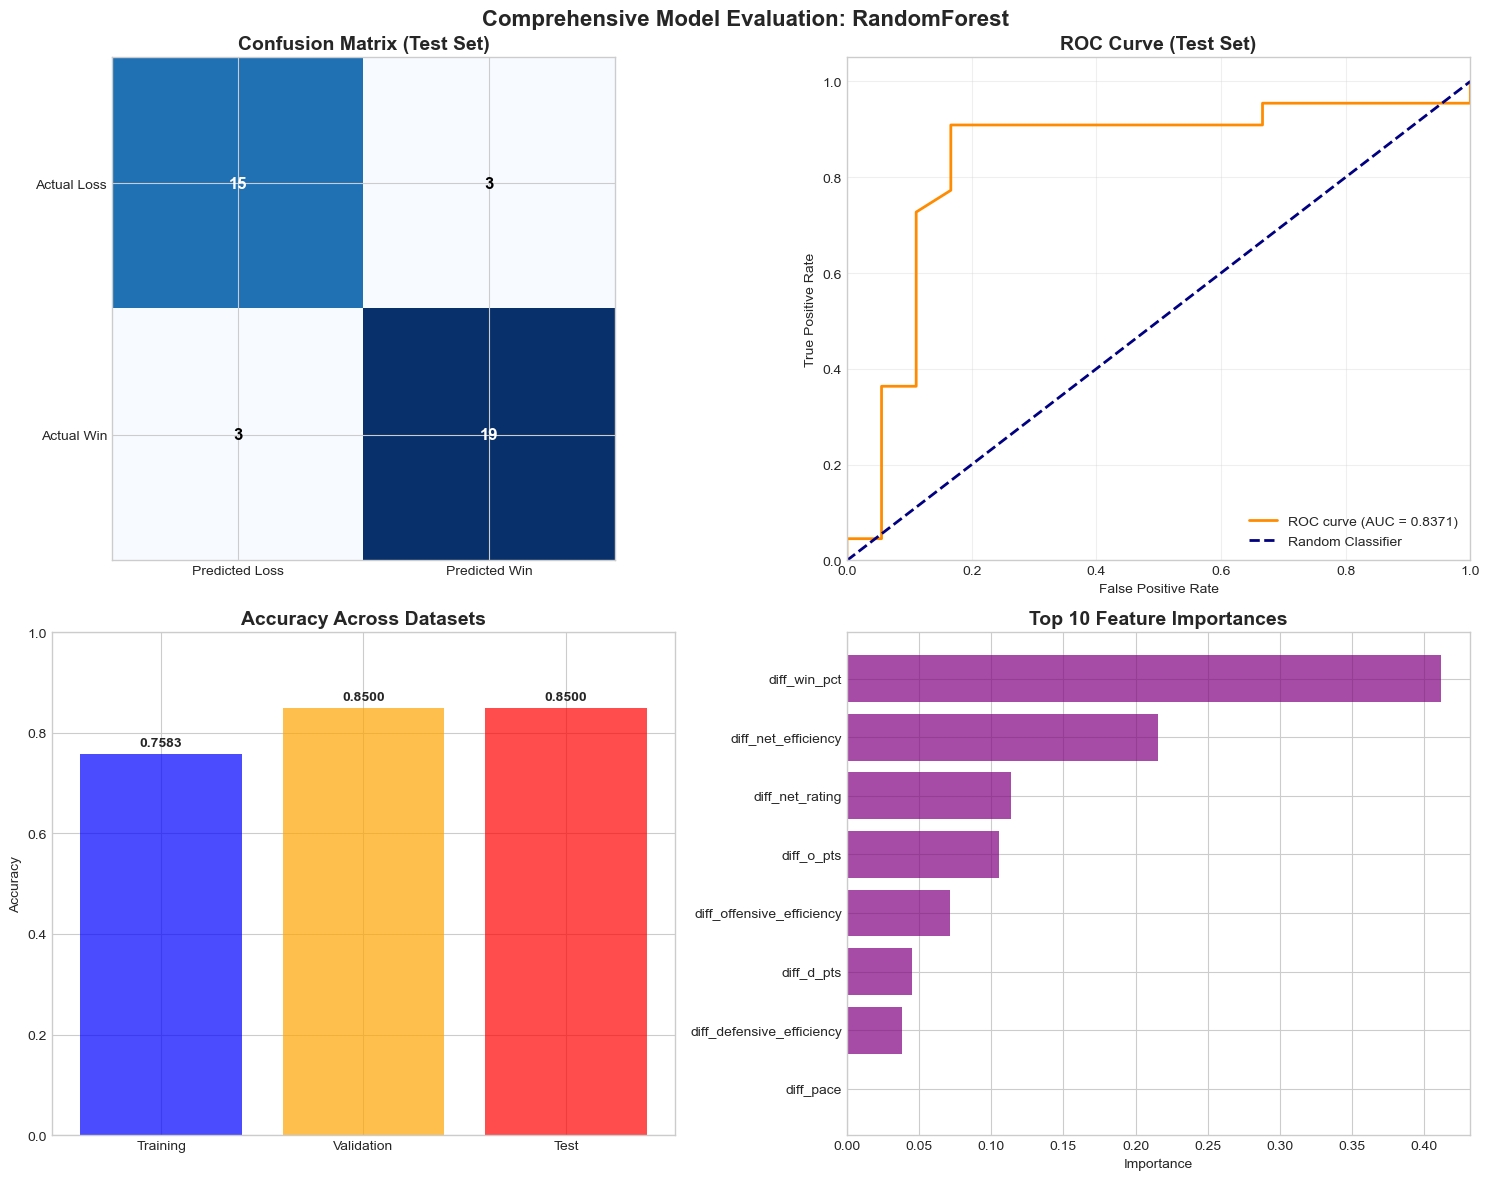


Detailed Performance Summary for RandomForest:
Training Accuracy: 0.7583
Validation Accuracy: 0.8500
Test Accuracy: 0.8500
Training-Validation Gap: -0.0917
Training-Test Gap: -0.0917
Test Precision: 0.8636
Test Recall: 0.8636
Test F1-Score: 0.8636
Test AUC: 0.8371

Confusion Matrix Details:
True Positives: 19
True Negatives: 15
False Positives: 3
False Negatives: 3
False Positive Rate: 0.1667
False Negative Rate: 0.1364


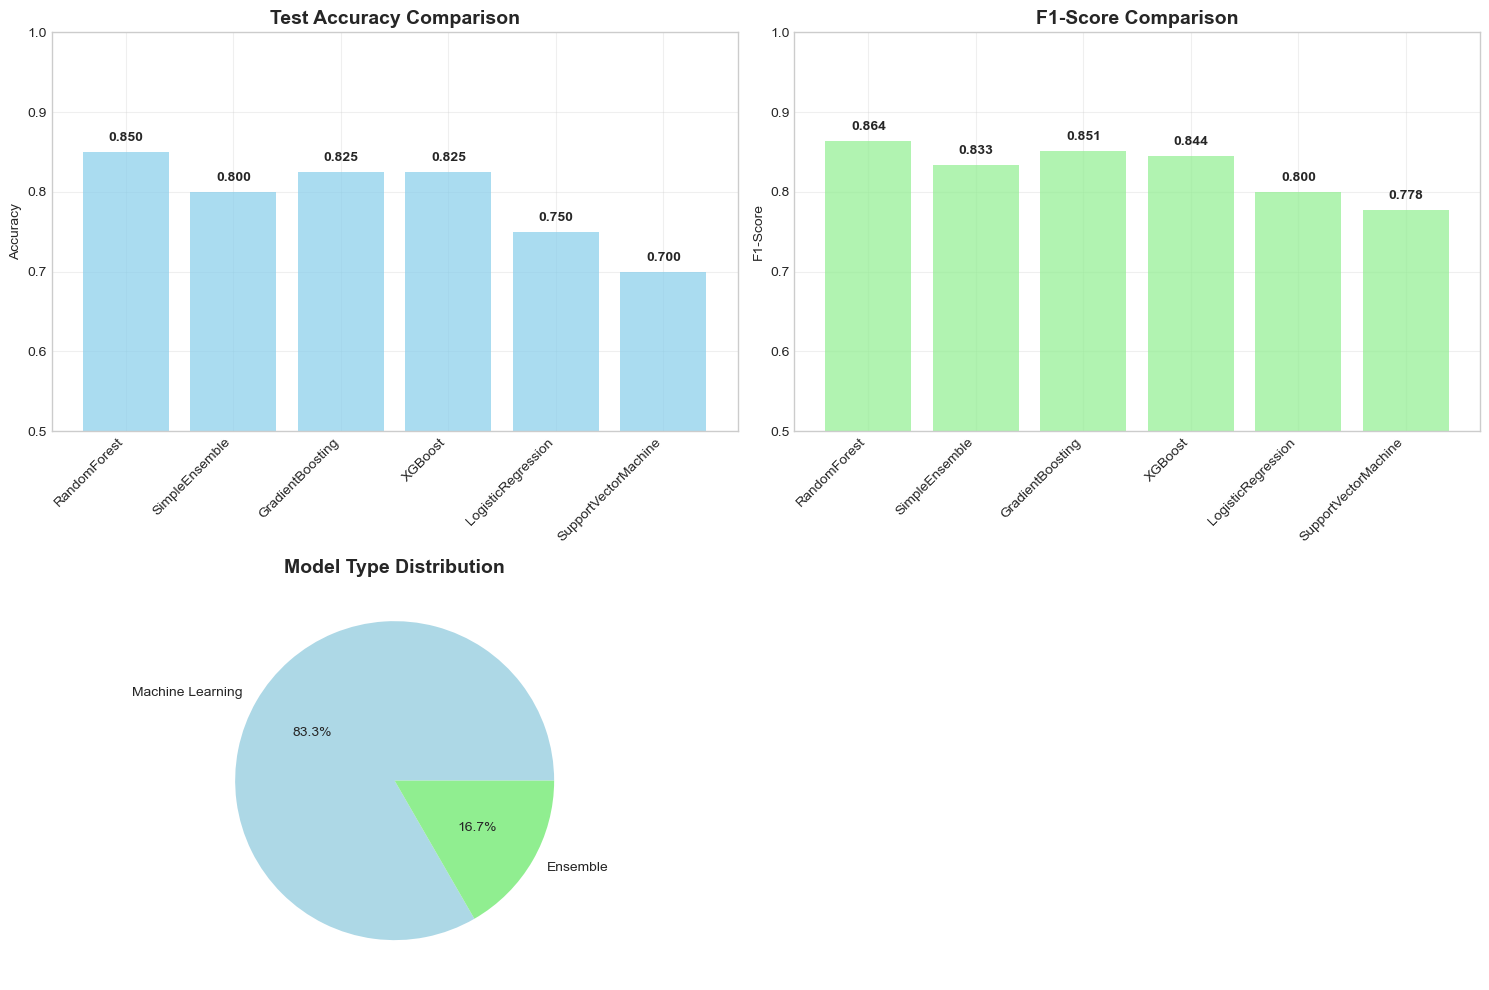


COMPREHENSIVE MODEL EVALUATION COMPLETED
Includes: Confusion Matrix, ROC Curve, and Performance Analysis


In [65]:


def create_comprehensive_evaluation(best_model, best_model_name, X_train, X_val, X_test, y_train, y_val, y_test, model_type='ml'):
    """Create comprehensive evaluation visualizations for the best model"""
    print(f"\nComprehensive Evaluation for {best_model_name}:")
    print("=" * 60)
    
    if model_type == 'ml' and not hasattr(best_model, 'classes_'):
        best_model.fit(X_train, y_train)
    
    if model_type == 'ml':
        y_train_pred = best_model.predict(X_train)
        y_val_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
        y_test_proba = best_model.predict_proba(X_test)[:, 1]
    else: 
        best_model.eval()
        with torch.no_grad():
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
            train_outputs = best_model(X_train_tensor)
            _, y_train_pred_tensor = torch.max(train_outputs, 1)
            y_train_pred = y_train_pred_tensor.cpu().numpy()
            
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
            val_outputs = best_model(X_val_tensor)
            _, y_val_pred_tensor = torch.max(val_outputs, 1)
            y_val_pred = y_val_pred_tensor.cpu().numpy()
            
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
            test_outputs = best_model(X_test_tensor)
            _, y_test_pred_tensor = torch.max(test_outputs, 1)
            y_test_pred = y_test_pred_tensor.cpu().numpy()
            y_test_proba = torch.softmax(test_outputs, 1)[:, 1].cpu().numpy()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Training-Validation Gap: {train_accuracy - val_accuracy:.4f}")
    print(f"Training-Test Gap: {train_accuracy - test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Comprehensive Model Evaluation: {best_model_name}', fontsize=16, fontweight='bold')
    
    cm = confusion_matrix(y_test, y_test_pred)
    im = axes[0, 0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[0, 0].set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks([0, 1])
    axes[0, 0].set_yticks([0, 1])
    axes[0, 0].set_xticklabels(['Predicted Loss', 'Predicted Win'])
    axes[0, 0].set_yticklabels(['Actual Loss', 'Actual Win'])
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0, 0].text(j, i, format(cm[i, j], 'd'),
                          ha="center", va="center",
                          color="white" if cm[i, j] > thresh else "black",
                          fontsize=12, fontweight='bold')
    
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve (Test Set)', fontsize=14, fontweight='bold')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True, alpha=0.3)
    
    accuracy_data = [train_accuracy, val_accuracy, test_accuracy]
    labels = ['Training', 'Validation', 'Test']
    colors = ['blue', 'orange', 'red']
    
    bars = axes[1, 0].bar(labels, accuracy_data, color=colors, alpha=0.7)
    axes[1, 0].set_ylim(0, 1.0)
    axes[1, 0].set_title('Accuracy Across Datasets', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Accuracy')
    
    for bar, accuracy in zip(bars, accuracy_data):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')
    
    if model_type == 'ml' and (hasattr(best_model, 'feature_importances_') or hasattr(best_model, 'coef_')):
        if hasattr(best_model, 'feature_importances_'):
            importance = best_model.feature_importances_
        else:
            importance = np.abs(best_model.coef_[0])
        
        feature_imp_df = pd.DataFrame({
            'feature': diff_columns,
            'importance': importance
        }).sort_values('importance', ascending=True).tail(10)  # Top 10 features
        
        axes[1, 1].barh(feature_imp_df['feature'], feature_imp_df['importance'], color='purple', alpha=0.7)
        axes[1, 1].set_title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Importance')
    else:
        axes[1, 1].hist(y_test_proba[y_test == 0], bins=20, alpha=0.7, label='Actual Loss', color='red')
        axes[1, 1].hist(y_test_proba[y_test == 1], bins=20, alpha=0.7, label='Actual Win', color='green')
        axes[1, 1].set_xlabel('Predicted Probability of Win')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr)
    }

def plot_training_history(best_model_name, model_type='ml'):
    """Plot training history for models that support it"""
    if model_type == 'nn':
        print(f"\nTraining History for {best_model_name}:")
        print("=" * 50)
        
        input_size = X_train_t.shape[1]
        nn_model_with_history, train_accuracies, val_accuracies = train_neural_network_with_history(
            X_train_t, y_train_t, X_val_t, y_val_t, input_size
        )
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
        plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
        plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        final_train_acc = train_accuracies[-1]
        final_val_acc = val_accuracies[-1]
        final_test_acc = nn_test_accuracy
        
        comparison_data = [final_train_acc, final_val_acc, final_test_acc]
        labels = ['Training', 'Validation', 'Test']
        colors = ['blue', 'orange', 'green']
        
        bars = plt.bar(labels, comparison_data, color=colors, alpha=0.7)
        plt.title('Final Accuracy Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1.0)
        
        for bar, accuracy in zip(bars, comparison_data):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return nn_model_with_history

def train_neural_network_with_history(X_train_t, y_train_t, X_val_t, y_val_t, input_size, epochs=200, patience=20):
    """Train neural network with history tracking"""
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = RegularizedNeuralNetwork(input_size=input_size, dropout_rate=0.5).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-3)
    
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        if epoch % 3 == 0:
            noise = torch.randn_like(X_train_t) * 0.01
            inputs = X_train_t + noise
        else:
            inputs = X_train_t
            
        outputs = model(inputs)
        loss = criterion(outputs, y_train_t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_t)
            _, train_preds = torch.max(train_outputs, 1)
            train_accuracy = (train_preds == y_train_t).float().mean().item()
            
            val_outputs = model(X_val_t)
            _, val_preds = torch.max(val_outputs, 1)
            val_accuracy = (val_preds == y_val_t).float().mean().item()
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, train_accuracies, val_accuracies

if final_comparison is not None:
    best_model_name = final_comparison.iloc[0]['Model']
    
    if best_model_name in model_comparator.results:
        best_model = model_comparator.results[best_model_name]['model']
        model_type = 'ml'
        evaluation_results = create_comprehensive_evaluation(
            best_model, best_model_name, 
            X_train_scaled, X_val_scaled, X_test_scaled, 
            y_train, y_val, y_test, 
            model_type
        )
        
    elif best_model_name == 'NeuralNetwork':
        best_model = nn_model
        model_type = 'nn'
        evaluation_results = create_comprehensive_evaluation(
            best_model, best_model_name,
            X_train_scaled, X_val_scaled, X_test_scaled,
            y_train, y_val, y_test,
            model_type
        )
        
        plot_training_history(best_model_name, model_type)
        
    elif best_model_name == 'SimpleEnsemble' and simple_ensemble is not None:
        best_model = simple_ensemble
        model_type = 'ensemble'
        evaluation_results = create_comprehensive_evaluation(
            best_model, best_model_name,
            X_train_scaled, X_val_scaled, X_test_scaled,
            y_train, y_val, y_test,
            model_type
        )
    
    print(f"\nDetailed Performance Summary for {best_model_name}:")
    print("=" * 50)
    print(f"Training Accuracy: {evaluation_results['train_accuracy']:.4f}")
    print(f"Validation Accuracy: {evaluation_results['val_accuracy']:.4f}")
    print(f"Test Accuracy: {evaluation_results['test_accuracy']:.4f}")
    print(f"Training-Validation Gap: {evaluation_results['train_accuracy'] - evaluation_results['val_accuracy']:.4f}")
    print(f"Training-Test Gap: {evaluation_results['train_accuracy'] - evaluation_results['test_accuracy']:.4f}")
    print(f"Test Precision: {evaluation_results['test_precision']:.4f}")
    print(f"Test Recall: {evaluation_results['test_recall']:.4f}")
    print(f"Test F1-Score: {evaluation_results['test_f1']:.4f}")
    print(f"Test AUC: {evaluation_results['test_auc']:.4f}")
    
    cm = evaluation_results['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nConfusion Matrix Details:")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"False Positive Rate: {fp/(fp+tn):.4f}")
    print(f"False Negative Rate: {fn/(fn+tp):.4f}")


def plot_final_model_comparison(final_comparison_df):
    """Create final comparison across all model types"""
    if final_comparison_df is None:
        return
    
    plt.figure(figsize=(15, 10))
    
    models = final_comparison_df['Model'].tolist()
    test_accuracies = final_comparison_df['Test_Accuracy'].tolist()
    test_f1_scores = final_comparison_df['Test_F1'].tolist()
    
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(models, test_accuracies, color='skyblue', alpha=0.7)
    plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.5, 1.0)
    plt.grid(True, alpha=0.3)
    
    for bar, accuracy in zip(bars1, test_accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(2, 2, 2)
    bars2 = plt.bar(models, test_f1_scores, color='lightgreen', alpha=0.7)
    plt.title('F1-Score Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0.5, 1.0)
    plt.grid(True, alpha=0.3)
    
    for bar, f1_score in zip(bars2, test_f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{f1_score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(2, 2, 3)
    model_types = final_comparison_df['Type'].value_counts()
    plt.pie(model_types.values, labels=model_types.index, autopct='%1.1f%%', 
            colors=['lightblue', 'lightgreen', 'lightcoral'])
    plt.title('Model Type Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

if final_comparison is not None:
    plot_final_model_comparison(final_comparison)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL EVALUATION COMPLETED")
print("Includes: Confusion Matrix, ROC Curve, and Performance Analysis")
print("="*80)